# 1. Import Kaggle data

In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.max_columns', None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# 2. Import Libraries

In [21]:
import matplotlib.pyplot as plt
from scipy import sparse
import seaborn as sns

from sklearn.compose import ColumnTransformer,TransformedTargetRegressor

# Preprocessing
from sklearn.impute import SimpleImputer,KNNImputer
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier , SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Accuracy/Error metrics
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score,roc_curve, roc_auc_score

# 3. Load Dataset

In [22]:
sample_data = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv")
train_data = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test_data = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

# 4. EDA (Exploratory Data Analysis)

## 4.1. Data Discription

The dataset contains 39,211 rows and 16 columns. Here's a brief description of the key columns:

- **last contact date:** Date of last contact (text).
- **age:** Age of the individual (integer).
- **job:** Type of job (categorical).
- **marital:** Marital status (categorical).
- **education:** Level of education (categorical).
- **default:** Whether the individual has credit default (yes/no).
- **balance:** Account balance (integer).
- **housing:** Whether the individual has a housing loan (yes/no).
- **loan:** Whether the individual has a personal loan (yes/no).
- **contact:** Type of communication contact (cellular/telephone).
- **duration:** Duration of the last contact (integer).
- **campaign:** Number of contacts performed during this campaign (integer).
- **pdays:** Number of days since the client was last contacted (integer).
- **previous:** Number of contacts performed before this campaign (integer).
- **poutcome:** Outcome of the previous campaign (categorical, many missing values).
- **target:** Outcome of the current campaign (yes/no).

In [23]:
# Perform basic statistical analysis for numerical columns
numerical_stats = train_data.describe()

numerical_stats

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


## 4.2. Histograms of Key Numerical Features

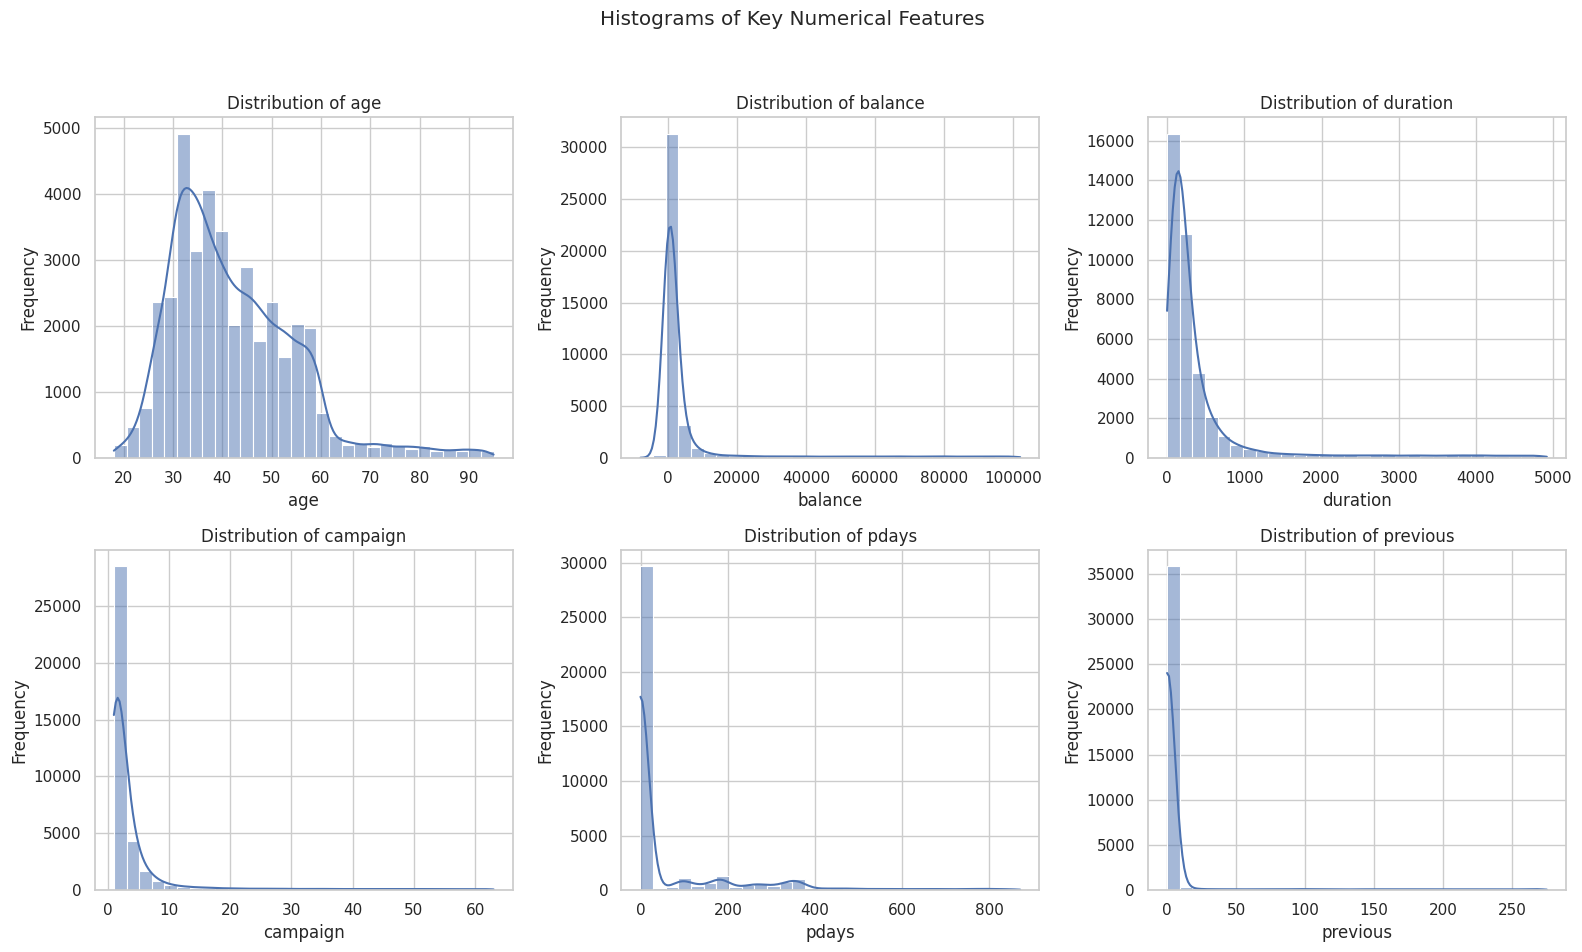

In [24]:
# Set up the visual style for the plots
sns.set(style="whitegrid")

# Visualize distributions of key numerical variables using histograms
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Histograms of Key Numerical Features')

# Plot histograms for selected numerical columns
columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
for col, ax in zip(columns, axes.flatten()):
    sns.histplot(train_data[col].dropna(), bins=30, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])


   - **Age:** The majority of individuals fall between ages 30 and 50, with a mean of 42 years.
   - **Balance:** There is a wide range in account balance, with some extreme values. The average balance is around 5,441, but outliers exist with balances over 100,000 and negative balances as low as -8,019.
   - **Duration:** The duration of the last contact varies significantly, with a median value of 197 seconds. However, some durations are as high as 4,918 seconds, indicating possible outliers.
   - **Campaign:** The number of contacts ranges from 1 to 63, but most clients have been contacted between 1-4 times.
   - **Pdays:** Most values for `pdays` are -1, indicating that many clients have not been contacted before this campaign. For those who were contacted, the values vary widely.
   - **Previous:** Similar to `pdays`, many individuals have not been contacted in previous campaigns, with a median value of 0.

## 4.3. Count Plots of Key Categorical Features

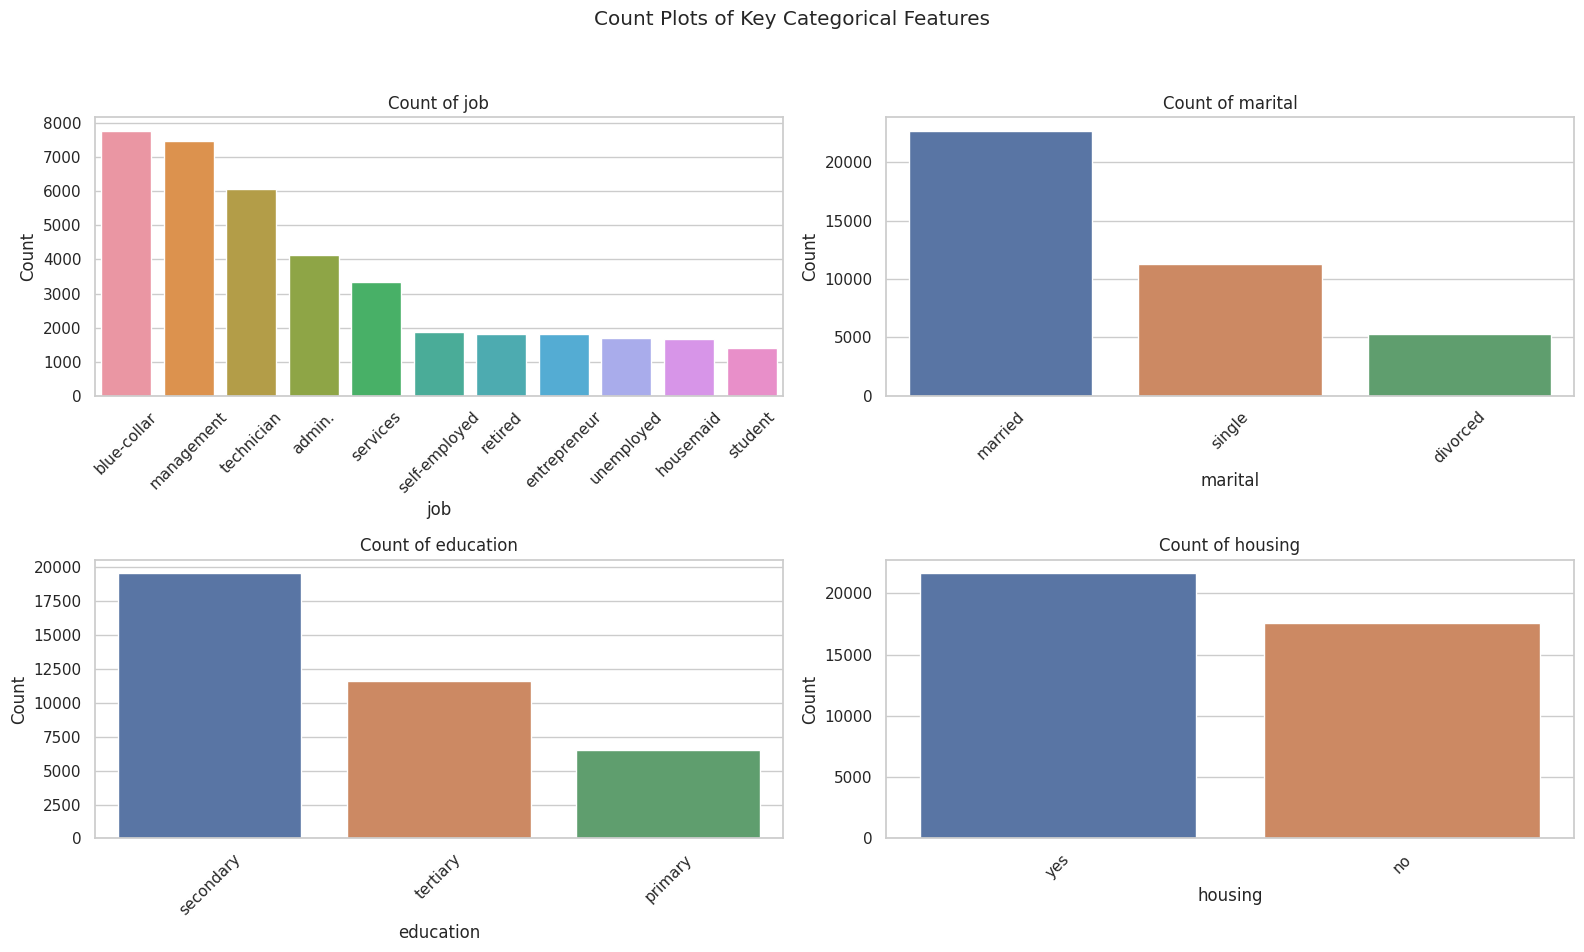

In [25]:
# Countplots for categorical variables to show frequency distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Count Plots of Key Categorical Features')

categorical_columns = ['job', 'marital', 'education', 'housing']
for col, ax in zip(categorical_columns, axes.flatten()):
    sns.countplot(data=train_data, x=col, ax=ax, order=train_data[col].value_counts().index)
    ax.set_title(f'Count of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

   - **Job:** The most common job types are blue-collar, management, and technician. There are also a few job categories with lower representation, such as housemaid and student.
   - **Marital Status:** The majority of the individuals are married, followed by single and divorced individuals.
   - **Education:** Most people have secondary education, followed by tertiary education, with a smaller proportion having primary education.
   - **Housing Loans:** Most individuals have a housing loan, with a significant number also not having one.

## 4.4. Correlation matrix

<Axes: >

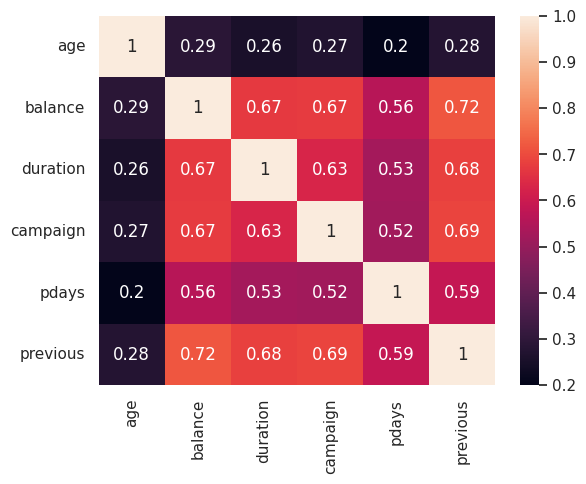

In [26]:
# Calculate the correlation matrix for the numerical features
columns_to_plot = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# Plot the correlation matrix using a heatmap
correlation_matrix = train_data[columns_to_plot].corr()
sns.heatmap(correlation_matrix, annot=True)

## 4.5. Key Findings from the Exploratory Data Analysis (EDA):

### **Insights:**
   - **Outliers:** The account balance shows extreme values that could affect model performance, requiring further investigation or treatment.
   - **Skewed Features:** Features like `campaign`, `pdays`, and `previous` are highly skewed with many zero or minimum values.
   - **Correlations:** `Balance` and `previous` contacts seem to influence multiple aspects, such as campaign duration and the number of interactions. `Campaign` and `duration` are also closely related, indicating that longer campaigns are associated with longer calls and higher balances.

# 5. Train-Validation Split

Split uses 80% of the data for training and 20% for validation

In [27]:
# Separating features and target variable in train data
x_train = train_data.drop(columns=['target'], axis=1)  # Features
y_train = train_data['target']  # Target variable

# For the test data, we do not have the target, so only X_test is present
x_test = test_data.copy()

# Performing the train-test split (typically we split training data for validation too)
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Show the shape of the resulting splits
(x_train_split.shape, x_test_split.shape, y_train_split.shape, y_test_split.shape)
# x_test.shape

((31368, 15), (7843, 15), (31368,), (7843,))

# 6. Data Cleaning/ Preprocessing

## 6.1. Removing Irrelevant Columns

- **Last Contact Date (dates):** It might not be relevant unless you want to extract time-based features from it.
- **Contact Method (cellular/telephone):** While this can indicate how a customer prefers to be reached, it might not be as critical in determining campaign success compared to other features.
- **Poutcome (Outcome of the Previous Campaign):** This is likely highly related to previous contacts but could be missing for many entries(~75% missing), limiting its usefulness.

In [28]:
# columns_to_drop = ['last contact date'] #,'contact','poutcome']

# x_train_split.drop(columns=columns_to_drop, inplace=True)
# x_test_split.drop(columns=columns_to_drop, inplace=True)
# x_test.drop(columns=columns_to_drop, inplace=True)

## 6.2. Handling Missing Values

Imputing missing values with "Unknown".

In [29]:
print(x_train_split.isna().sum())
print(x_test_split.isna().sum())
x_test.isna().sum()

last contact date        0
age                      0
job                    185
marital                  0
education             1172
default                  0
balance                  0
housing                  0
loan                     0
contact               8267
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             23578
dtype: int64
last contact date       0
age                     0
job                    44
marital                 0
education             295
default                 0
balance                 0
housing                 0
loan                    0
contact              2069
duration                0
campaign                0
pdays                   0
previous                0
poutcome             5873
dtype: int64


last contact date       0
age                     0
job                    59
marital                 0
education             390
default                 0
balance                 0
housing                 0
loan                    0
contact              2684
duration                0
campaign                0
pdays                   0
previous                0
poutcome             7508
dtype: int64

In [30]:
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# imputerknn = KNNImputer(n_neighbors=2)

# x_train_split["job"] = imputerknn.fit_transform(x_train_split["job"].values.reshape(-1,1))[:,0]
# x_train_split["education"] = imputer.fit_transform(x_train_split["education"].values.reshape(-1,1))[:,0]
# x_train_split["contact"] = imputer.fit_transform(x_train_split["contact"].values.reshape(-1,1))[:,0]
# x_train_split["poutcome"] = imputer.fit_transform(x_train_split["poutcome"].values.reshape(-1,1))[:,0]

# x_test_split["job"] = imputerknn.fit_transform(x_test_split["job"].values.reshape(-1,1))[:,0]
# x_test_split["education"] = imputer.fit_transform(x_test_split["education"].values.reshape(-1,1))[:,0]
# x_test_split["contact"] = imputer.fit_transform(x_test_split["contact"].values.reshape(-1,1))[:,0]
# x_test_split["poutcome"] = imputer.fit_transform(x_test_split["poutcome"].values.reshape(-1,1))[:,0]

# x_test["job"] = imputerknn.fit_transform(x_test["job"].values.reshape(-1,1))[:,0]
# x_test["education"] = imputer.fit_transform(x_test["education"].values.reshape(-1,1))[:,0]
# x_test["contact"] = imputer.fit_transform(x_test["contact"].values.reshape(-1,1))[:,0]
# x_test["poutcome"] = imputer.fit_transform(x_test["poutcome"].values.reshape(-1,1))[:,0]

# x_train_split["job"].fillna("Unkown", inplace = True)
# x_train_split["education"].fillna("Unkown", inplace = True)
# x_train_split["contact"].fillna("Unkown", inplace = True)
# x_train_split["poutcome"].fillna("Unkown", inplace = True)

# x_test_split["job"].fillna("Unkown", inplace = True)
# x_test_split["education"].fillna("Unkown", inplace = True)
# x_test_split["contact"].fillna("Unkown", inplace = True)
# x_test_split["poutcome"].fillna("Unkown", inplace = True)

# x_test["job"].fillna("Unkown", inplace = True)
# x_test["education"].fillna("Unkown", inplace = True)
# x_test["contact"].fillna("Unkown", inplace = True)
# x_test["poutcome"].fillna("Unkown", inplace = True)

print(x_train_split.isna().sum())
print(x_test_split.isna().sum())
x_test.isna().sum()


last contact date        0
age                      0
job                    185
marital                  0
education             1172
default                  0
balance                  0
housing                  0
loan                     0
contact               8267
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             23578
dtype: int64
last contact date       0
age                     0
job                    44
marital                 0
education             295
default                 0
balance                 0
housing                 0
loan                    0
contact              2069
duration                0
campaign                0
pdays                   0
previous                0
poutcome             5873
dtype: int64


last contact date       0
age                     0
job                    59
marital                 0
education             390
default                 0
balance                 0
housing                 0
loan                    0
contact              2684
duration                0
campaign                0
pdays                   0
previous                0
poutcome             7508
dtype: int64

## 6.3. Encoding Categorical Variables

In [31]:
print(x_train_split.shape)
x_test_split.shape

(31368, 15)


(7843, 15)

In [32]:
x_train_split['last contact date'] = pd.to_datetime(x_train_split['last contact date'])
x_train_split['month'] = x_train_split['last contact date'].dt.month
x_train_split['weekday'] = x_train_split['last contact date'].dt.weekday
# x_train_split = x_train_split.drop(columns = 'last contact date',inplace = True)
x_train_split.drop(columns='last contact date', inplace=True)

x_test_split['last contact date'] = pd.to_datetime(x_test_split['last contact date'])
x_test_split['month'] = x_test_split['last contact date'].dt.month
x_test_split['weekday'] = x_test_split['last contact date'].dt.weekday
# x_test_split = x_test_split.drop(columns = 'last contact date',inplace = True)
x_test_split.drop(columns='last contact date', inplace=True)

x_test['last contact date'] = pd.to_datetime(x_test['last contact date'])
x_test['month'] = x_test['last contact date'].dt.month
x_test['weekday'] = x_test['last contact date'].dt.weekday
# x_test = x_test.drop(columns = 'last contact date',inplace = True)
x_test.drop(columns='last contact date', inplace=True)

num = ['balance','duration','campaign']
cat = ['loan','housing','job','education','marital','default','contact','poutcome']

ct = ColumnTransformer([
    ("num", StandardScaler(), num),
    ("cat", OneHotEncoder(), cat)    
],remainder= 'passthrough')

x_train_encoded = pd.DataFrame(ct.fit_transform(x_train_split), columns=ct.get_feature_names_out())
x_test_encoded = pd.DataFrame(ct.transform(x_test_split), columns=ct.get_feature_names_out())
x_test1 = pd.DataFrame(ct.transform(x_test), columns=ct.get_feature_names_out())
# train_data_encoded

le = LabelEncoder()
le.fit(y_train_split)
y_train_encoded = le.transform(y_train_split)
y_test_encoded = le.transform(y_test_split)
y_test_encoded.shape
x_train_encoded

,num__balance,num__duration,num__campaign,cat__loan_no,cat__loan_yes,cat__housing_no,cat__housing_yes,cat__job_admin.,cat__job_blue-collar,cat__job_entrepreneur,cat__job_housemaid,cat__job_management,cat__job_retired,cat__job_self-employed,cat__job_services,cat__job_student,cat__job_technician,cat__job_unemployed,cat__job_nan,cat__education_primary,cat__education_secondary,cat__education_tertiary,cat__education_nan,cat__marital_divorced,cat__marital_married,cat__marital_single,cat__default_no,cat__default_yes,cat__contact_cellular,cat__contact_telephone,cat__contact_nan,cat__poutcome_failure,cat__poutcome_other,cat__poutcome_success,cat__poutcome_nan,remainder__age,remainder__pdays,remainder__previous,remainder__month,remainder__weekday
0,-0.313577,-0.194373,-0.010589,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,46.0,-1.0,0.0,5.0,0.0
1,-0.324526,-0.478030,-0.414670,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,43.0,-1.0,0.0,2.0,6.0
2,-0.332400,-0.302371,-0.414670,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,-1.0,0.0,11.0,4.0
3,-0.332092,-0.350514,-0.414670,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,47.0,-1.0,0.0,8.0,5.0
4,-0.329755,-0.422079,-0.111609,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,45.0,-1.0,0.0,8.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31363,-0.325141,-0.347912,-0.212629,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,34.0,-1.0,0.0,7.0,5.0
31364,-0.264181,-0.420778,-0.212629,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,43.0,264.0,2.0,2.0,5.0
31365,-0.342980,-0.180060,-0.414670,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,58.0,-1.0,0.0,5.0,3.0
31366,-0.309701,-0.420778,-0.313649,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,33.0,103.0,1.0,5.0,0.0


# 7. Models

## 7.1. Dummy Classifier

In [40]:
# dummy_clf = DummyClassifier()
# model = dummy_clf.fit(x_train_encoded,y_train_encoded)
# y_pred = model.predict(x_test_encoded)
# pred = model.predict(x_test1)
# # print(pred) # 0.46260

# report = classification_report(y_test_encoded,y_pred)
# print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      6645
           1       0.00      0.00      0.00      1198

    accuracy                           0.85      7843
   macro avg       0.42      0.50      0.46      7843
weighted avg       0.72      0.85      0.78      7843



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**0.46260** on Kaggle submission

## 7.2. Ridge Classifier

In [34]:
# ridge_classifier = RidgeClassifier()
# ridge_classifier.fit(x_train_encoded, y_train_encoded)
# y_pred = ridge_classifier.predict(x_test_encoded)
# pred = ridge_classifier.predict(x_test1)
# print(pred) # 0.61551

# report = classification_report(y_test_encoded,y_pred)
# print("Classification Report:\n", report)

[0 0 0 ... 0 0 0]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      6645
           1       0.57      0.21      0.31      1198

    accuracy                           0.86      7843
   macro avg       0.72      0.59      0.61      7843
weighted avg       0.83      0.86      0.83      7843



**0.61551** on Kaggle submission

## 7.3. Logistic Regression with GridSearchCV

In [16]:
# lr_clf = LogisticRegression()

# param_grid = {
#     "penalty":["l1", "l2", "elasticnet", None],
#     "dual":[False],
# #     "tol":0.0001,
#     "C":[1, 2, 3, 4, 5],
# #     "fit_intercept":True,
# #     "intercept_scaling":1,
# #     "class_weight":None,
#     "solver":["liblinear","sag", "saga"],
#     "max_iter":[100, 1000],
# #     "max_iter":[100, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000],
#     "multi_class":["auto", "ovr", "multinomial"],
#     "warm_start":[True, False]
# #     "n_jobs":[-1]
# #     "l1_ratio":None
# }

# lr_clf_grid_cv = GridSearchCV(estimator=lr_clf,
#                               param_grid=param_grid,
#                               cv=3,
#                               verbose=True,
#                               n_jobs=-1)

# lr_clf_grid_cv.fit(x_train_encoded, y_train_encoded)

In [17]:
# lr_clf_grid_cv.best_estimator_

In [18]:
# lr_clf_grid_cv.best_params_

In [35]:
# regressor = LogisticRegression(C=2, max_iter=1000, penalty='l1', solver='liblinear')
# regressor.fit(x_train_encoded, y_train_encoded)
# y_pred = regressor.predict(x_test_encoded)
# pred = regressor.predict(x_test1)

# print(pred) # 0.62797

# report = classification_report(y_test_encoded,y_pred)
# print("Classification Report:\n", report)

[0 0 0 ... 0 0 0]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      6645
           1       0.58      0.23      0.32      1198

    accuracy                           0.86      7843
   macro avg       0.72      0.60      0.62      7843
weighted avg       0.83      0.86      0.83      7843



**0.6149** on Kaggle submission 

**0.62797** on Kaggle submission with GridSearchCV

## 7.4. Random Forest Classifier with RandomizedSearchCV and GridSearchCV

In [39]:
regressor = RandomForestClassifier()
model = TransformedTargetRegressor(regressor= regressor).fit(x_train_encoded,y_train_encoded)
# Predict on the train data
y_pred = model.predict(x_test_encoded)
# Predict on the test data
pred = model.predict(x_test1)
print(pred) # 0.71413

# Generate the classification report
report = classification_report(y_test_encoded,y_pred)
print("Classification Report:\n", report)

[0 0 0 ... 0 0 0]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      6645
           1       0.50      0.13      0.21      1198

    accuracy                           0.85      7843
   macro avg       0.68      0.55      0.56      7843
weighted avg       0.81      0.85      0.81      7843



In [21]:
# # Import necessary libraries
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV
# import numpy as np

# # Define the parameter grid for RandomizedSearchCV
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],            # Number of trees in the forest
#     'max_depth': [10, 20, 30, None],                      # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],                      # Minimum number of samples required to split a node
#     'min_samples_leaf': [1, 2, 4],                        # Minimum number of samples required at each leaf node
#     'max_features': ['auto', 'sqrt', 'log2'],             # Number of features to consider at each split
#     'bootstrap': [True, False],                           # Whether bootstrap samples are used when building trees
#     'criterion': ['gini', 'entropy']                      # Criterion to measure the quality of a split
# }

# # Create the base Random Forest model
# rf = RandomForestClassifier(random_state=42)

# # Use RandomizedSearchCV to find the best hyperparameters
# random_search = RandomizedSearchCV(
#     estimator=rf, 
#     param_distributions=param_grid, 
#     n_iter=50,                   # Number of parameter settings that are sampled
#     cv=5,                        # 5-fold cross-validation
#     verbose=2,                   # Verbosity level: displays training progress
#     random_state=42,             # Ensures reproducibility of results
#     n_jobs=-1                    # Use all available processors
# )

# # Fit the random search model to the data (replace X_train, y_train with your dataset)
# random_search.fit(x_train_encoded,y_train_encoded)

# # Output the best parameters and the best score from the search
# print(f"Best Parameters: {random_search.best_params_}")
# print(f"Best Score (CV): {random_search.best_score_}")

# # Make predictions using the best estimator
# y_pred = random_search.best_estimator_.predict(X_test)


In [22]:
# random_search.best_estimator_

In [23]:
# # Import necessary libraries
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report

# # Assuming X_train, y_train are your training data
# # Replace with your actual feature matrix and target

# # Define the parameter grid for exhaustive search
# param_grid = {
#     'n_estimators': [100, 300, 500],             # Number of trees in the forest
#     'max_depth': [10, 20, 30],                   # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],             # Minimum number of samples required to split a node
#     'min_samples_leaf': [1, 2, 4],               # Minimum number of samples required to be at a leaf node
#     'max_features': ['auto', 'sqrt'],            # Number of features to consider at every split
#     'bootstrap': [True, False],                  # Whether bootstrap samples are used when building trees
#     'criterion': ['gini', 'entropy']             # Function to measure the quality of a split
# }

# # Create the Random Forest model
# rf = RandomForestClassifier(random_state=42)

# # Use GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# # Fit the GridSearchCV model
# grid_search.fit(x_train_encoded,y_train_encoded)

# # Print the best parameters and score
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Cross-Validation Score: {grid_search.best_score_}")
# grid_search.best_estimator_

# # Optional: Evaluate the model on the test set (X_test, y_test)
# y_pred = grid_search.best_estimator_.predict(X_test)
# print(classification_report(y_test, y_pred))


In [36]:
# regressor = RandomForestClassifier(n_estimators= 400, min_samples_split= 10, min_samples_leaf= 1, max_features= 'log2', max_depth= None, criterion= 'gini', bootstrap= True)
# model = TransformedTargetRegressor(regressor= regressor).fit(x_train_encoded,y_train_encoded)

# y_pred = model.predict(x_test_encoded)
# pred = model.predict(x_test1)

# print(pred) # 0.71413

# report = classification_report(y_test_encoded,y_pred)
# print("Classification Report:\n", report)

[0 0 0 ... 0 0 0]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92      6645
           1       0.60      0.39      0.48      1198

    accuracy                           0.87      7843
   macro avg       0.75      0.67      0.70      7843
weighted avg       0.85      0.87      0.86      7843



**0.71413** on Kaggle submission 
**0.715** on Kaggle submission with GridSearchCV

## 7.5. XGBoost with Grid Search

In [26]:
# import xgboost as xgb
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import f1_score

# xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# # Step 3: Set up hyperparameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.8, 1],
#     'colsample_bytree': [0.8, 1],
# }

# # Step 4: Perform Grid Search for Hyperparameter Tuning
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='f1_macro',
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )

# grid_search.fit(x_train_encoded,y_train_encoded)

# # Step 5: Train the best model
# best_model = grid_search.best_estimator_
# # y_pred = best_model.predict(X_val)

# # Step 6: Evaluate the performance
# # f1 = f1_score(y_val, y_pred, average='macro')
# print("Best Parameters:", grid_search.best_params_)
# print("Macro F1 Score with XGBoost:", f1)

In [47]:
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report

# Step 1: Define the XGBoost model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    colsample_bytree=1,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=100,
    subsample=1
)

# Step 2: Train the model
best_xgb_model.fit(x_train_encoded,y_train_encoded)
y_pred = best_xgb_model.predict(x_test_encoded)
pred = best_xgb_model.predict(x_test1)
print(pred) # 0.72635
report = classification_report(y_test_encoded,y_pred)
print("Classification Report:\n", report)

[0 0 0 ... 0 0 0]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92      6645
           1       0.59      0.47      0.52      1198

    accuracy                           0.87      7843
   macro avg       0.75      0.70      0.72      7843
weighted avg       0.86      0.87      0.86      7843



**0.72635** on Kaggle submission with GridSearchCV(Best Score)

# 8. ROC Curve for top 3 Models

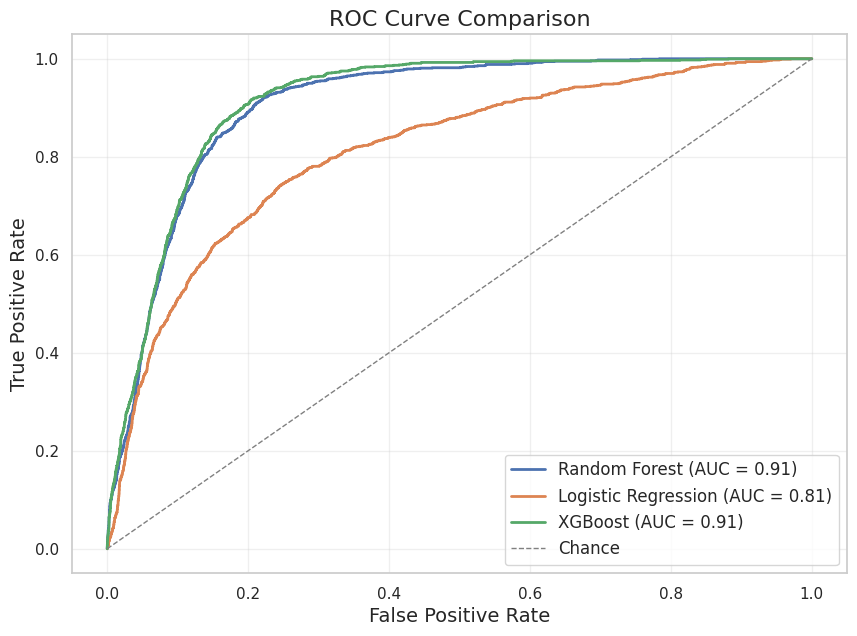

In [48]:
# Initialize models
rf = RandomForestClassifier(n_estimators= 400, min_samples_split= 10, min_samples_leaf= 1, max_features= 'log2', max_depth= None, criterion= 'gini', bootstrap= True,random_state=42)
lr = LogisticRegression(C=2, max_iter=1000, penalty='l1', solver='liblinear',random_state=42)
xgb = xgb.XGBClassifier( colsample_bytree=1,learning_rate=0.1,max_depth=7,n_estimators=100,subsample=1,random_state=42)

# Train models
rf.fit(x_train_encoded,y_train_encoded)
lr.fit(x_train_encoded,y_train_encoded)
xgb.fit(x_train_encoded,y_train_encoded)

# Predict probabilities for the positive class
rf_probs = rf.predict_proba(x_test_encoded)[:, 1]
lr_probs = lr.predict_proba(x_test_encoded)[:, 1]
xgb_probs = xgb.predict_proba(x_test_encoded)[:, 1]

# Calculate ROC curve and AUC
rf_fpr, rf_tpr, _ = roc_curve(y_test_encoded, rf_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_encoded, lr_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test_encoded, xgb_probs)

rf_auc = roc_auc_score(y_test_encoded, rf_probs)
lr_auc = roc_auc_score(y_test_encoded, lr_probs)
xgb_auc = roc_auc_score(y_test_encoded, xgb_probs)

# Plot the ROC curves
plt.figure(figsize=(10, 7))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})", linewidth=2)
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {lr_auc:.2f})", linewidth=2)
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {xgb_auc:.2f})", linewidth=2)

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance', linewidth=1)

# Add labels and legend
plt.title("ROC Curve Comparison", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


# 9. Submission

In [28]:
submit = pd.DataFrame(columns = ['id','target'])
submit['id'] = [ i for i in range(len(pred))]
submit['target'] = pred
submit['target'] = submit['target'].replace(0,'no')
submit['target'] = submit['target'].replace(1,'yes')
submit.to_csv('submission.csv',index=False)
submit

,id,target
0,0,no
1,1,no
2,2,no
3,3,no
4,4,yes
...,...,...
9995,9995,no
9996,9996,yes
9997,9997,no
9998,9998,no
